# Learning to modify images with Python

`pillow` seems to be the right package to do this. I'm going to experiment and loosely follow [this tutorial](https://automatetheboringstuff.com/chapter17/)

In [1]:
from PIL import Image

## Loading images

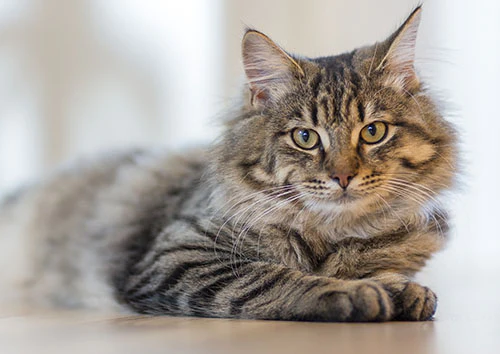

In [7]:
cat = Image.open("cat.png")
cat

In [4]:
cat.size

(500, 354)

## Copy and Paste in images

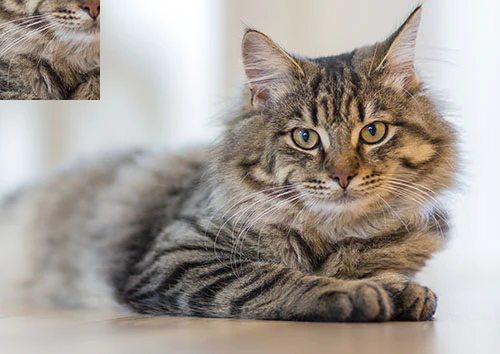

In [8]:
catcopy = cat
catcopy.paste(cat.crop((250,170,350,270)), (0,0))
catcopy

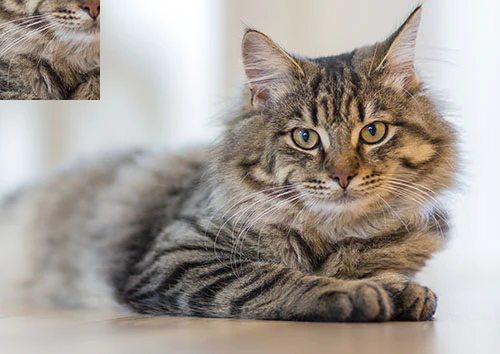

In [9]:
cat

So if just use `catcopy = cat` it just creates a new variable referencing to the same object. I need to use `catcopy = cat.copy()`

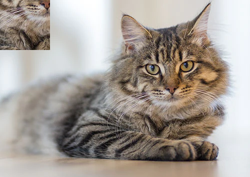

In [13]:
quartercat = cat.resize((int(cat.size[0]/2), int(cat.size[1]/2)))
quartercat

## Rotate and Transpose

Images can be rotated with the `rotate()` method, which returns a new Image object of the rotated image and leaves the original Image object unchanged. The argument to `rotate()` is a single integer or float representing the number of degrees to rotate the image counterclockwise. 

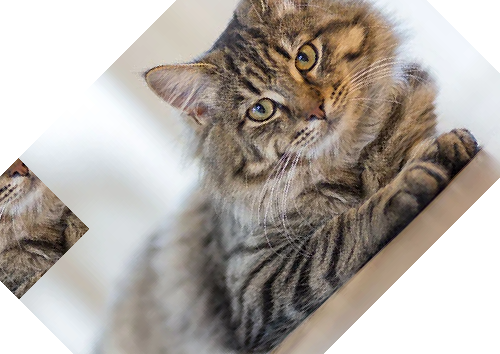

In [15]:
cat.rotate(45)

So the image maintains its size and the parts that are out of the canvas are _cropped out_.

On Windows, a black background is used to fill in any gaps made by the rotation. On OS X, transparent pixels are used for the gaps instead.

*The width and height of the image change when the image is rotated 90 or 270 degrees*. If you rotate an image by some other amount, the original dimensions of the image are maintained. ––––––– hmm not in my experience:

In [18]:
print(cat.size, cat.rotate(45).size, cat.rotate(90).size, cat.rotate(270).size)

(500, 354) (500, 354) (500, 354) (500, 354)


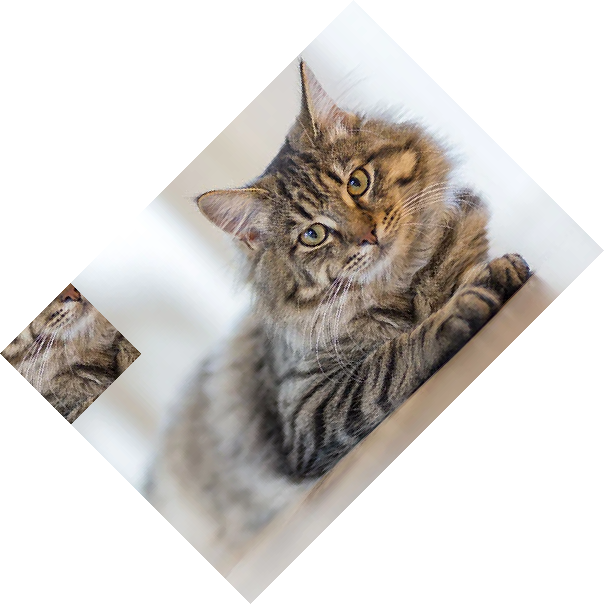

In [19]:
cat.rotate(45, expand=True)

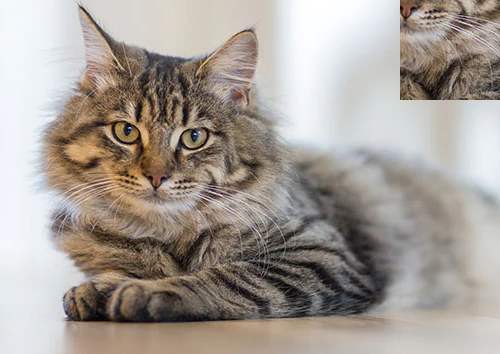

In [25]:
cat.transpose(0)

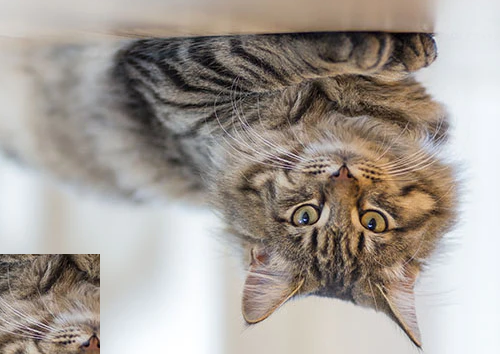

In [26]:
cat.transpose(1)

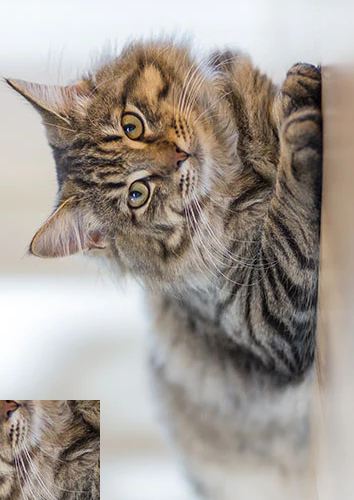

In [27]:
cat.transpose(2)

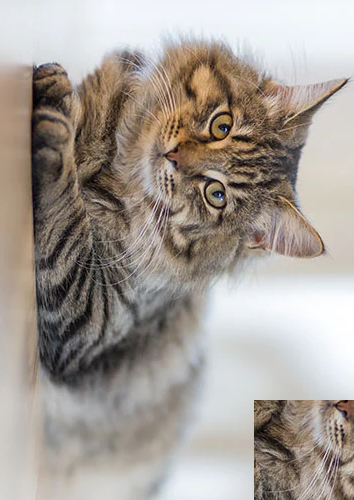

In [32]:
cat.transpose(6)

## Changing Individual Pixels

In [33]:
cat.getpixel((0,0)) # gets the color of the pixel at (0,0) in RGBA

(83, 70, 52, 255)

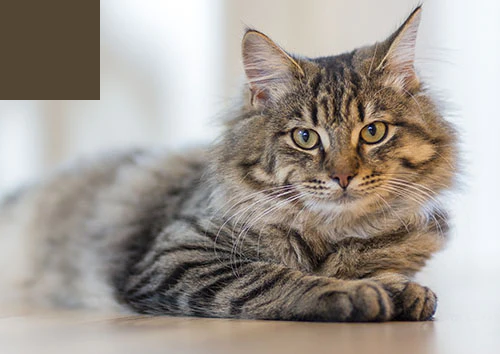

In [36]:
for x in range(100):
    for y in range(100):
        cat.putpixel((x,y), (83,70,52,255))

cat

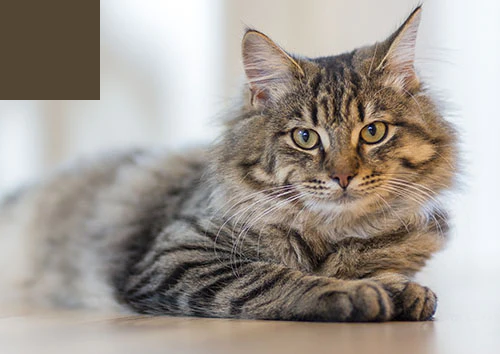

In [35]:
cat

## Drawing on Images

In [37]:
from PIL import ImageDraw

image = Image.new('RGBA', (200,200), 'white')
draw = ImageDraw.Draw(image)

In [41]:
draw.line([(0, 0), (199, 0), (199, 199), (0, 199), (0, 0)], fill='black')
draw.rectangle((20, 30, 60, 60), fill='blue')
draw.ellipse((120, 30, 160, 60), fill='red')
draw.polygon(((57, 87), (79, 62), (94, 85), (120, 90), (103, 113)), fill='brown')
for i in range(100, 200, 10):
           draw.line([(i, 0), (200, i - 100)], fill='green')

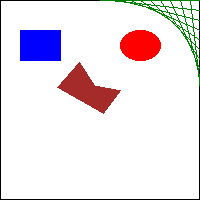

In [42]:
image

# Experimenting with test type modifications

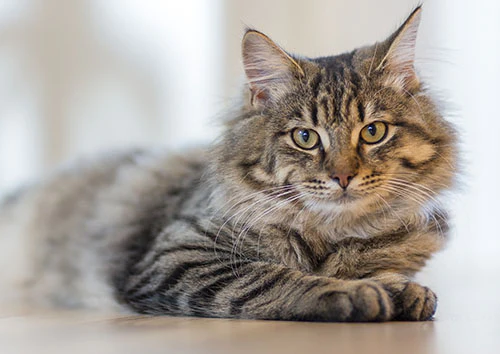

In [289]:
cat = Image.open("cat.png")
cat

In [290]:
def crop_image(image: Image, dims):
    assert dims < image.size, "New dimensions have to be smaller for cropping to be possible"
    crop = image.crop(((image.size[0]-dims[0])/2, (image.size[1]-dims[1])/2, image.size[0] - (image.size[0]-dims[0])/2, image.size[1] - (image.size[1]-dims[1])/2))
    
    return crop

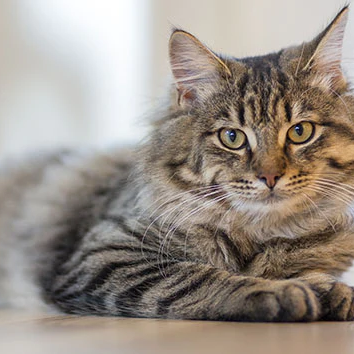

In [291]:
def square_image(image:Image):
    if image.size[0] > image.size[1]:
        squared = crop_image(image, (image.size[1], image.size[1]))
    elif image.size[0] < image.size[1]:
        squared = crop_image(image, (image.size[0], image.size[0]))
    assert squared.size[0] == squared.size[1], "Error: Image wasn't squared correctly"
    return squared

square_cat = square_image(cat)
IMAGE_SIZE = catcopy.size[0]
square_cat

## Crop image into patches

In [292]:
PATCH_SIZE = 50


In [293]:
print(IMAGE_SIZE)

if IMAGE_SIZE%PATCH_SIZE != 0:
    IMAGE_SIZE = IMAGE_SIZE//PATCH_SIZE*PATCH_SIZE
    square_cat = crop_image(square_cat, (IMAGE_SIZE, IMAGE_SIZE))

square_cat.size

354


(350, 350)

In [294]:
patches = []
for y in range(0, IMAGE_SIZE, PATCH_SIZE):
    for x in range(0, IMAGE_SIZE, PATCH_SIZE):
        patches.append(square_cat.crop((x, y, x + PATCH_SIZE, y + PATCH_SIZE)))


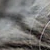

In [296]:
patches[30]

## Visualize these patches

In [297]:
span = 3
patchedcat = Image.new('RGBA', (int(IMAGE_SIZE*(span/PATCH_SIZE+1)), int(IMAGE_SIZE*(span/PATCH_SIZE+1))))
patchedcat.size

(371, 371)

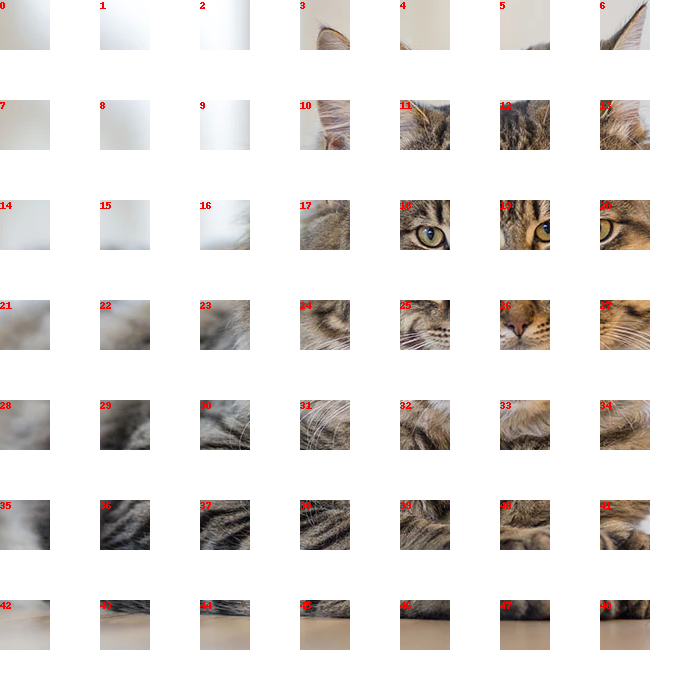

In [307]:
i=0
span = 2
patchedcat = Image.new('RGBA', (IMAGE_SIZE*span, IMAGE_SIZE*span))
for y in range(0, IMAGE_SIZE, PATCH_SIZE):
    for x in range(0, IMAGE_SIZE, PATCH_SIZE):
        patch = patches[i].copy()
        draw = ImageDraw.Draw(patch)
        draw.text((0,0), str(i), 'red')
        patchedcat.paste(patch, (int(x*span),int(y*span)))
        i+=1
patchedcat

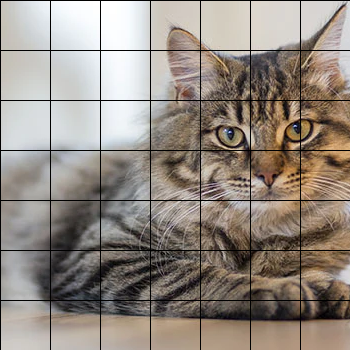

In [299]:
patchedcat = square_cat.copy()
draw = ImageDraw.Draw(patchedcat)
for y in range(0, IMAGE_SIZE, PATCH_SIZE):
    draw.line((0,y,IMAGE_SIZE,y), 'black')
for x in range(0, IMAGE_SIZE, PATCH_SIZE):
    draw.line((x,0,x,IMAGE_SIZE), 'black')

patchedcat


## Random perturbation

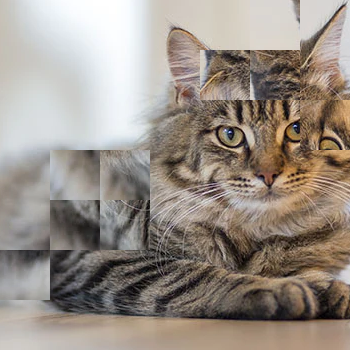

In [300]:
ROT_PROPORTION = 0.25

from random import random

i=0
for y in range(0, IMAGE_SIZE, PATCH_SIZE):
    for x in range(0, IMAGE_SIZE, PATCH_SIZE):
        if random() <= ROT_PROPORTION :
            angle = 90
        else:
            angle = 0
        patchedcat.paste(patches[i].rotate(angle, expand=False), (int(x),int(y)))
        i+=1
patchedcat

## Perturbation by clumps
### Central Rotation

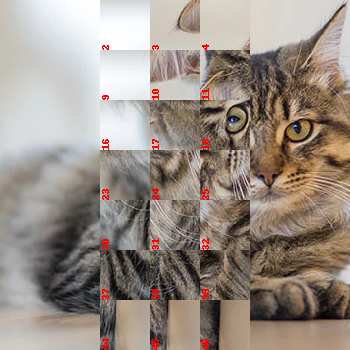

In [310]:
ROT_PROPORTION = 0.25

from random import random

patchedcat = square_cat.copy()

i=0
for y in range(0, IMAGE_SIZE, PATCH_SIZE):
    for x in range(0, IMAGE_SIZE, PATCH_SIZE):
        patch = patches[i].copy()
        if 1<i%(IMAGE_SIZE/PATCH_SIZE)<IMAGE_SIZE/PATCH_SIZE-2:#if IMAGE_SIZE/4 <= x <= 3*IMAGE_SIZE/4 and IMAGE_SIZE/4 <= y <= 3*IMAGE_SIZE/4:# and random() <= ROT_PROPORTION:
            draw = ImageDraw.Draw(patch)
            draw.text((0,0), str(i), 'red')
            angle = 90
        else:
            angle = 0
        patchedcat.paste(patch.rotate(angle, expand=False), (int(x),int(y)))
        i+=1
patchedcat

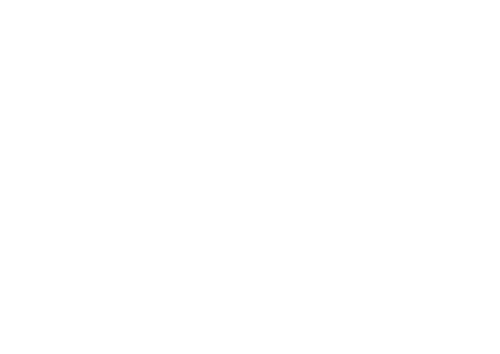

In [256]:
catcopy = cat.copy()
draw = ImageDraw.Draw(catcopy)
draw.rectangle((0,0,IMAGE_SIZE,IMAGE_SIZE), (255,0,0,0))
catcopy

In [4]:
spoty = Image.open("spotify.jpg").convert('LA')